In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import string
from nltk.stem.porter import PorterStemmer
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math

from scipy.sparse import hstack
from sklearn.model_selection import KFold

# Data Pre-processing

In [81]:
def pre_process_df(df):
    df["gender"] = df["gender"].astype('category')
    df["topic"] = df["topic"].astype('category')
    df["sign"] = df["sign"].astype('category')

    df["gender_cat"] = df["gender"].cat.codes
    df["topic_cat"] = df["topic"].cat.codes
    df["sign_cat"] = df["sign"].cat.codes
    
    df["gender_cat"] = df["gender_cat"].astype('category')
    df["topic_cat"] = df["topic_cat"].astype('category')
    df["sign_cat"] = df["sign_cat"].astype('category')

def get_word_count(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
    

In [82]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442961 entries, 0 to 442960
Data columns (total 8 columns):
post.id    442961 non-null int64
user.id    442961 non-null int64
gender     442961 non-null object
topic      442961 non-null object
sign       442961 non-null object
date       442961 non-null object
text       442961 non-null object
age        442961 non-null int64
dtypes: int64(3), object(5)
memory usage: 27.0+ MB


In [84]:
pre_process_df(train)
pre_process_df(test)
get_word_count(train)
get_word_count(test)

## Data Processing on the Text Column

## Grouping the data by USER ID
### (found no change in gender,age, or topic across user.id at time of collecting data)

In [85]:
def remove_spaces_from_text_col(df):
    
    # replace &nbsp; or Non-Breaking spaces with normal spaces
    df['text'] = df['text'].apply(lambda x: re.sub('&nbsp;', ' ',str(x)))
    # remove duplicate spaces
    df['text'] = df['text'].apply(lambda x: re.sub(' +', ' ',str(x)))
    # strip spaces around the sentence string
    df['text'] = df['text'].apply(lambda x: str(x).strip())


def group_by_user_id_col(df):
    # group by user id and get all the categorical variables
    cat = df.groupby(['user.id'])['topic','gender', 'sign','topic_cat','gender_cat', 'sign_cat' ].first()
    cat.columns = ['topic','gender', 'sign','topic_cat','gender_cat', 'sign_cat' ]
    
    # group by user id and get all text written by the user
    text = df.groupby(['user.id'])['text'].apply(lambda x:' '.join(x))
    
    # check for age column and get the age of each user
    if 'age' in df.columns:
        age = df.groupby(['user.id'])['age'].agg(np.average)
        return cat, text, age
        
    return cat, text

def feature_creation(df):
    # get the total word count for each user
    tot_word_count = df.groupby(['user.id'])['word_count'].agg(np.sum)
    tot_word_count.name = 'tot_word_count'
    
    # get average word count for each user
    avg_word_count = df.groupby(['user.id'])['word_count'].agg(np.average)
    avg_word_count.name = 'avg_word_count'
    
    # get the number of posts by each user
    num_of_text = df.groupby(['user.id'])['user.id'].agg(['count'])
    num_of_text.columns = ['num_of_text']
    
    return tot_word_count, avg_word_count, num_of_text

def create_final_df(feature_dfs): # pass list of feature data frames created; returns concatenated data frame
    
    final_df = pd.concat(feature_dfs, axis=1)
    final_df = final_df.reset_index()
    
    return final_df
        

In [86]:
remove_spaces_from_text_col(train)
cat, text, age = group_by_user_id_col(train)
tot_word_count, avg_word_count, num_of_text = feature_creation(train)
final_df = create_final_df([cat, text, age, tot_word_count, avg_word_count, num_of_text])

In [87]:
final_df["gender_cat"] = final_df["gender_cat"].astype('category')
final_df["topic_cat"] = final_df["topic_cat"].astype('category')
final_df["sign_cat"] = final_df["sign_cat"].astype('category')

In [88]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns (total 12 columns):
user.id           12880 non-null int64
topic             12880 non-null object
gender            12880 non-null object
sign              12880 non-null object
topic_cat         12880 non-null category
gender_cat        12880 non-null category
sign_cat          12880 non-null category
text              12880 non-null object
age               12880 non-null int64
tot_word_count    12880 non-null int64
avg_word_count    12880 non-null float64
num_of_text       12880 non-null int64
dtypes: category(3), float64(1), int64(4), object(4)
memory usage: 945.5+ KB


# Exploring the data

### Gender Division

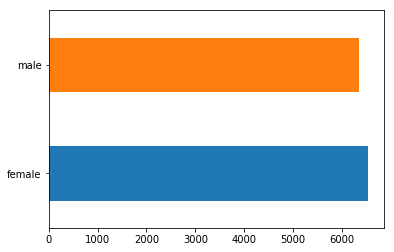

In [89]:
# train.groupby(['user.id'])['gender'].value_counts().plot(kind='barh')
final_df['gender'].value_counts().plot(kind='barh')
plt.show()

### Top 10 Topics by Frequency

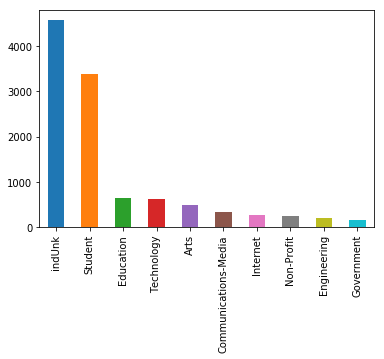

In [90]:
final_df['topic'].value_counts()[:10].plot(kind='bar')
plt.show()

### Distribution of Signs

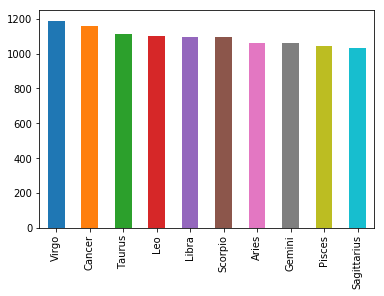

In [91]:
final_df['sign'].value_counts()[:10].plot(kind='bar')
plt.show()

# Working with the text column grouped data frame
## Removing stop words and punctuation

In [92]:
def text_processing(df):
    # get stop words from NLTK
    stop = stopwords.words('english')
    
    # remove stop words from the text
    df['text_processed'] = df['text'].apply(lambda x : " ".join(x for x in x.split() if x not in stop))
    
    # count special characters
    df['specials'] = df['text_processed'].apply(lambda x: len(re.sub('[^\^&*#!-]+' ,'', x)))
    
    # count normal punctuations
    df['punc'] = df['text_processed'].apply(lambda x: len(re.sub('[^.?]+' ,'', x)))
    
    # removing punctuation 
    df['text_processed'] = df['text_processed'].str.replace('[^\w\s]','')
    
    # ignore case
    df['text_processed'] = df['text_processed'].str.lower()
    
    # count number of numerical values in the text
    df['numerics'] = df['text_processed'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    # remove numbers from the text
    df['text_processed'] = df['text_processed'].str.replace('\d+', '')
    
    # get word roots
    df['text_processed'] = df['text_processed'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return df


In [93]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arnab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [94]:
final_df = text_processing(final_df)

In [95]:
#final_df['specials'] = final_df['text_processed'].apply(lambda x: len(re.sub('[^\^&*#]+' ,'', x)))
final_df['count_slang'] = final_df.text_processed.str.count('lol|tbt|smh|tbh|lel|lmao|omg|wtf|ikr|lmfao')
final_df['numerics_num_of_text'] = final_df['numerics']/final_df['num_of_text']
final_df['specials_num_of_text'] = final_df['specials']/final_df['num_of_text']
final_df['punc_num_of_text'] = final_df['punc']/final_df['num_of_text']


In [96]:
# final_df.drop(['specials'], axis=1, inplace=True)
final_df.text[2]

"Not too much exciting has happened this weekend, I've just been really busy. I've worked Saturday, Sunday, and am going in today to work 4-close and it's urlLink Memorials Day . I hope I make lots and lots of urlLink money -- hopefully. I really like my new job as a 'server assistant' at Mahi-Mah's. The people there are really cool and pretty laid back about things; except Cherie. She is urlLink gay . She's the sidework Nazi. I like everyone else though, especially the girls. I finally got to detail my car yesterday. It smells good on the inside and is... well, shiny? It sucks having an old car because no matter how well you wash and clean it, it's still not going to have the same flare as it would if it were a suped up 97' v-tec Civic Si. Oh well, I should be getting a new car within the next year or so anyways. Saturday me and Derrick decided to skip youth group. It just isn't as pumped as it use to be. Maybe it's the fact that there is like 3x the younger urlLink kids and none of t

In [97]:
final_df.head(7)

,user.id,topic,gender,sign,topic_cat,gender_cat,sign_cat,text,age,tot_word_count,avg_word_count,num_of_text,text_processed,specials,punc,numerics,count_slang,numerics_num_of_text,specials_num_of_text,punc_num_of_text
0,1,indUnk,male,Sagittarius,39,1,8,Doritos Fuel of Space urlLink : Ian Myers NASA...,17,2384,76.903226,31,doritos fuel space urllink ian myers nasa new ...,26,165,14,1,0.451613,0.838710,5.322581
1,3,indUnk,female,Leo,39,0,5,"Yeah, I set up this blog so Heather would be h...",16,1643,205.375000,8,yeah i set blog heather would happyshe better ...,39,355,14,31,1.750000,4.875000,44.375000
2,4,Student,male,Aquarius,34,1,0,Not too much exciting has happened this weeken...,17,535,535.000000,1,not much exciting happened weekend ive really ...,6,32,5,0,5.000000,6.000000,32.000000
3,5,Accounting,female,Pisces,0,0,7,European Pilgrimage For High school Students o...,47,9931,451.409091,22,european pilgrimage for high school student st...,158,443,67,1,3.045455,7.181818,20.136364
4,6,Student,male,Pisces,34,1,7,Last night's dream is very blurry. The only de...,16,125684,189.854985,662,last night dream blurry the detail i remember ...,3821,10625,964,128,1.456193,5.771903,16.049849
5,7,indUnk,male,Cancer,39,1,2,"June 21, 2004 SPAIN V PORTUGAL Good for Euro ...",25,704,234.666667,3,june spain v portugal good euro portugal the i...,15,33,8,0,2.666667,5.000000,11.000000
6,12,indUnk,male,Aries,39,1,1,"Well, 1 day left... Less than 36 hours and I w...",23,2224,222.400000,10,well day left le hour i presence favorite band...,11,454,11,2,1.100000,1.100000,45.400000


# Extracting TF-IDF from the text data

In [98]:
# extract tf_idf for 1000 words with highest tf-idf values across all documents
# parameters: 
# min_df = 5 , ignore terms that appear in less than 5 documents
# max_df = 0.5, ignore terms that appear in more than 50% of the documents"
vectorizer = TfidfVectorizer(min_df=5, max_features=1000)
X_tfidf = vectorizer.fit_transform(final_df['text_processed']) 

In [99]:
X_tfidf = X_tfidf.todense()

In [100]:
# extract the features created on the final training dataframe
features_used = ['topic_cat', 'avg_word_count','num_of_text','count_slang']
X_feature = final_df[features_used]
# stack the tf-idf and other features together
X = np.concatenate((X_tfidf,X_feature.values), axis=1)
# get the outcome variable from the data frame
y = final_df.age

X.shape

## K-Fold cross validation

test_mse_avg_means = []
test_mse_avg_stds = []
test_mae_avg_means = []
test_mae_avg_stds = []
for i in range(1):
    kf = KFold(n_splits=10, shuffle=True)

    kfold_linreg = LinearRegression()
    test_mse = []
    test_mae = []

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
    
        # train model
        kfold_linreg.fit(X_train,y_train)
    
        y_pred = kfold_linreg.predict(X_test)
    
        mse = mean_squared_error(y_test,y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        test_mse.append(mse)
        test_mae.append(mae)

    #test mae
    std_test_mae = np.std(test_mae)
    avg_test_mae = np.mean(test_mae)
    test_mae_avg_means.append(avg_test_mae)
    test_mae_avg_stds.append(std_test_mae)
    
    #test_mse
    std_test_mse = np.std(test_mse)
    avg_test_mse = np.mean(test_mse)
    test_mse_avg_means.append(avg_test_mse)
    test_mse_avg_stds.append(std_test_mse)

In [101]:
print(np.mean(test_mae_avg_means))
print(np.mean(test_mae_avg_stds))
print(np.mean(test_mse_avg_means))
print(np.mean(test_mse_avg_stds))

4.236558933313924
0.12735133584297095
32.31741508438814
2.0104227095651552


## Checking different features

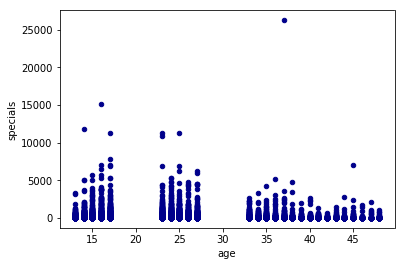

In [104]:
ax1 = final_df.plot.scatter(x='age',
                       y='specials',
                       c='DarkBlue')

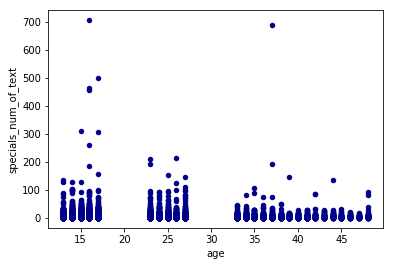

In [105]:
ax2 = final_df.plot.scatter(x='age',
                       y='specials_num_of_text',
                       c='DarkBlue')

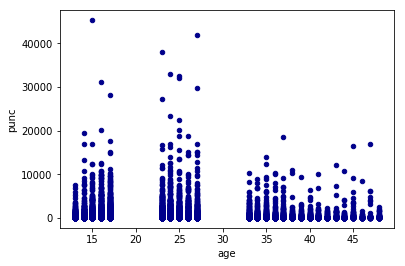

In [106]:
ax3 = final_df.plot.scatter(x='age',
                       y='punc',
                       c='DarkBlue')

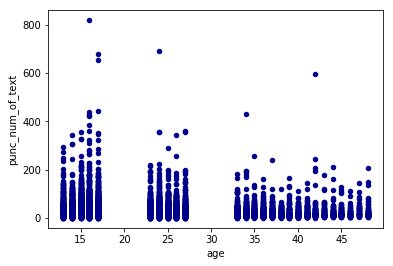

In [107]:
ax4 = final_df.plot.scatter(x='age',
                       y='punc_num_of_text',
                       c='DarkBlue')

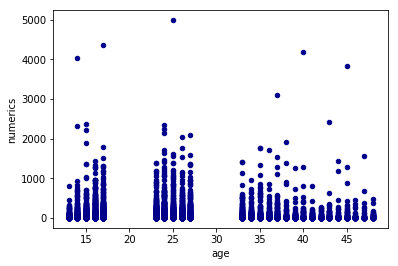

In [108]:
ax5 = final_df.plot.scatter(x='age',
                       y='numerics',
                       c='DarkBlue')

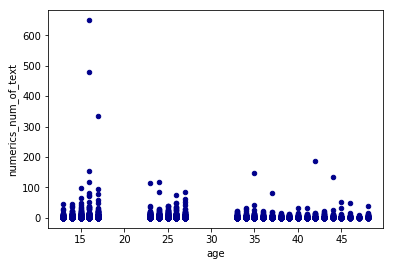

In [109]:
ax6 = final_df.plot.scatter(x='age',
                       y='numerics_num_of_text',
                       c='DarkBlue')

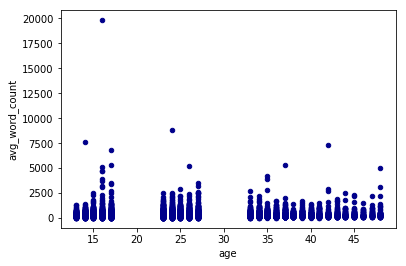

In [110]:
ax7 = final_df.plot.scatter(x='age',
                       y='avg_word_count',
                       c='DarkBlue')

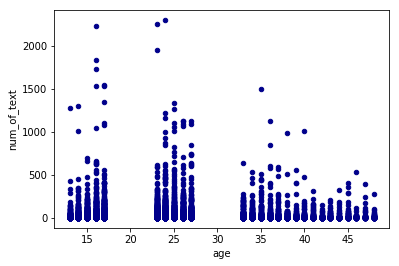

In [111]:
ax8 = final_df.plot.scatter(x='age',
                       y='num_of_text',
                       c='DarkBlue')

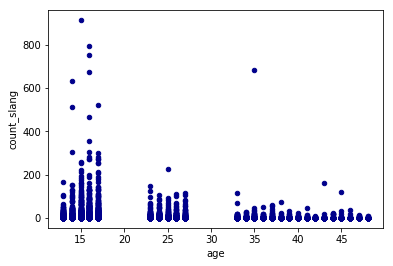

In [112]:
ax9 = final_df.plot.scatter(x='age',
                       y='count_slang',
                       c='DarkBlue')

In [113]:
# extract the features created on the final training dataframe
features_used = ['topic_cat', 'avg_word_count','num_of_text','count_slang', 'numerics_num_of_text','punc_num_of_text','specials_num_of_text']
X_feature = final_df[features_used]
# stack the tf-idf and other features together
X = np.concatenate((X_tfidf,X_feature.values), axis=1)
# get the outcome variable from the data frame
y = final_df.age

X.shape

(12880, 1007)

In [114]:
## K-Fold cross validation

test_mse_avg_means = []
test_mse_avg_stds = []
test_mae_avg_means = []
test_mae_avg_stds = []
for i in range(1):
    kf = KFold(n_splits=10)

    kfold_linreg = LinearRegression(normalize=True)
    test_mse = []
    test_mae = []

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
    
        # train model
        kfold_linreg.fit(X_train,y_train)
    
        y_pred = kfold_linreg.predict(X_test)
    
        mse = mean_squared_error(y_test,y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        test_mse.append(mse)
        test_mae.append(mae)

    #test mae
    std_test_mae = np.std(test_mae)
    avg_test_mae = np.mean(test_mae)
    test_mae_avg_means.append(avg_test_mae)
    test_mae_avg_stds.append(std_test_mae)
    
    #test_mse
    std_test_mse = np.std(test_mse)
    avg_test_mse = np.mean(test_mse)
    test_mse_avg_means.append(avg_test_mse)
    test_mse_avg_stds.append(std_test_mse)

In [115]:
print(np.mean(test_mae_avg_means))
print(np.mean(test_mae_avg_stds))
print(np.mean(test_mse_avg_means))
print(np.mean(test_mse_avg_stds))

4.226358552245648
0.1106721242874888
32.261049577971896
2.067344554103002


In [116]:
print(np.mean(test_mae_avg_means))
print(np.mean(test_mae_avg_stds))
print(np.mean(test_mse_avg_means))
print(np.mean(test_mse_avg_stds))

4.226358552245648
0.1106721242874888
32.261049577971896
2.067344554103002


## Making the model

In [117]:
# split the data into 80 percent train and 20 percent test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4200)

In [118]:
# make a linear regression model
linreg = LinearRegression()

linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns (total 20 columns):
user.id                 12880 non-null int64
topic                   12880 non-null object
gender                  12880 non-null object
sign                    12880 non-null object
topic_cat               12880 non-null category
gender_cat              12880 non-null category
sign_cat                12880 non-null category
text                    12880 non-null object
age                     12880 non-null int64
tot_word_count          12880 non-null int64
avg_word_count          12880 non-null float64
num_of_text             12880 non-null int64
text_processed          12880 non-null object
specials                12880 non-null int64
punc                    12880 non-null int64
numerics                12880 non-null int64
count_slang             12880 non-null int64
numerics_num_of_text    12880 non-null float64
specials_num_of_text    12880 non-null float64
punc_num_of_text

In [120]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns (total 20 columns):
user.id                 12880 non-null int64
topic                   12880 non-null object
gender                  12880 non-null object
sign                    12880 non-null object
topic_cat               12880 non-null category
gender_cat              12880 non-null category
sign_cat                12880 non-null category
text                    12880 non-null object
age                     12880 non-null int64
tot_word_count          12880 non-null int64
avg_word_count          12880 non-null float64
num_of_text             12880 non-null int64
text_processed          12880 non-null object
specials                12880 non-null int64
punc                    12880 non-null int64
numerics                12880 non-null int64
count_slang             12880 non-null int64
numerics_num_of_text    12880 non-null float64
specials_num_of_text    12880 non-null float64
punc_num_of_text

In [121]:
avg_test_mse = np.mean(test_mse)
avg_test_mse

32.261049577971896

## Making predictions

In [122]:
remove_spaces_from_text_col(test)
cat, text = group_by_user_id_col(test)
tot_word_count, avg_word_count, num_of_text = feature_creation(test)
test_df = create_final_df([cat, text, tot_word_count, avg_word_count, num_of_text])

In [123]:
test_df = text_processing(test_df)

In [124]:
test_df["gender_cat"] = test_df["gender_cat"].astype('category')
test_df["topic_cat"] = test_df["topic_cat"].astype('category')
test_df["sign_cat"] = test_df["sign_cat"].astype('category')

In [125]:
test_df['count_slang'] = test_df.text_processed.str.count('lol|tbt|smh|tbh|lel|lmao|omg|wtf|ikr')
test_df['numerics_num_of_text'] = test_df['numerics']/test_df['num_of_text']
test_df['specials_num_of_text'] = test_df['specials']/test_df['num_of_text']
test_df['punc_num_of_text'] = test_df['punc']/test_df['num_of_text']
test_df.head(2)

,user.id,topic,gender,sign,topic_cat,gender_cat,sign_cat,text,tot_word_count,avg_word_count,num_of_text,text_processed,specials,punc,numerics,count_slang,numerics_num_of_text,specials_num_of_text,punc_num_of_text
0,2,Military,male,Taurus,26,1,10,I finally saw Nathan's tattoo tonight. I like ...,833,119.000000,7,i finally saw nathans tattoo tonight i like it...,1,60,6,0,0.857143,0.142857,8.571429
1,8,indUnk,male,Aquarius,39,1,0,Today was the last day and the shortest. We ha...,11790,170.869565,69,today last day shortest we one session lasted ...,205,625,147,0,2.130435,2.971014,9.057971


In [126]:
features_used

['topic_cat',
 'avg_word_count',
 'num_of_text',
 'count_slang',
 'numerics_num_of_text',
 'punc_num_of_text',
 'specials_num_of_text']

In [127]:
# get the tf-idf of the same vocabulary of words learnt while fitting
X_test = vectorizer.transform(test_df['text_processed'])
X_test = X_test.todense()
# get the same feature from the test data as from the train data set
X_test_cat = test_df[features_used]
# stack the tf-idf and extracted features together
X_test_mat = np.concatenate((X_test,X_test_cat.values), axis=1)

In [128]:
X_test_mat.shape

(6440, 1007)

In [129]:
# predict on the test data
y_pred_test = linreg.predict(X_test_mat)

In [130]:
# write predictions to file
y_pred_test = pd.Series(y_pred_test)
predictions = pd.concat([test_df['user.id'], y_pred_test], axis=1)
predictions.columns = ['user.id','age']
predictions.age = np.floor(predictions.age)
predictions.to_csv('./predictions_text_test.csv', index=False)